# Proof-of-concept: Classification of review deception via a neural network

We now wish to move on to a deep-learning approach to fake review opinion spam detection, shown in numerous papers and studies to be an effective method of classification. 
In this notebook, in a similar fashion to the other notebooks in this directory, we will use the small dataset with minimal features and set up a very basic neural network using Tensorflow and Keras.
Let's start by importing the modules we need.

In [25]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import text
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

Now, let's start by getting our data. We use the get_data_frame function from the training helpers file, and split it into our X and Y (data and labels). 

It's been shown that a 70/30 train/test split is generally quite good, with a 70/30 train/validation split on the training data.

Training data is used to adjust weights, validation is used to make sure that these weight changes result in an increase in accuracy. Test data is used to run the final set of weights over data it's never seen before for final validation and to produce an accuracy.

In [33]:
from scripts import training_helpers as th
df = th.get_data_frame()

X = df['review']
y = df['deceptive']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

We're dealing with a tonne of features, so let's use the keras Tokenizer, which lets us choose a number of the most commonly occuring words in our vocab. We'll set this number to 2000, to get rid of the least important ones, and then fit it on our data.

In [27]:
NUM_WORDS = 2000
tokenizer = text.Tokenizer(num_words=NUM_WORDS)
tokenizer.fit_on_texts(X)

Now let's define a function that takes a list of reviews and converts it to a list of tfidf vectors based on the above dictionary.

In [28]:
def tokenize(data):
    return tokenizer.texts_to_matrix(data, mode='tfidf')

train_data = tokenize(X_train)
test_data = tokenize(X_test)

Lets take a look at these tfidf vectors and the shape of them.

In [29]:
print(train_data[0])

[0.        1.9429853 1.6775115 ... 0.        0.        0.       ]


Looks good. Now that our data is prepared, lets create our neural network.

Let's create a basic network with one hidden layer of 4 nodes, fully connected (Dense). 

The first layer needs to specify the size of the input in 'input_shape', which is the number of features in an input. Its output size will be the first parameter (4). In this case, we use a very small number of nodes as it's a very small dataset, so 4 is optimal to prevent overfitting.

The following layers can infer the size.

We use the Adam optimizer, which is a replacement optimizer for stochastic gradient descent, and the binary_crossentropy loss function, which is the binary log loss function.

In [7]:
model = keras.Sequential([
    keras.layers.Dense(4, activation=tf.nn.relu, input_shape=(NUM_WORDS,)),
    keras.layers.Dense(4, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])
 
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4)                 8004      
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
Total params: 8,029
Trainable params: 8,029
Non-trainable params: 0
_________________________________________________________________


Now let's train and validate the model. We fit it on the training data, using 70% for training (weight adjustment) and 30% for validation. Validation is important as it's data that hasn't been seen in the training, so we get a feel for how well the model generalizes and make sure overfitting does not occur. In general, how good a model is can be judged based on how low it's validation loss is.

Batch size is how many chunks we want to split out data up into. We cant pass the entire dataset in one epoch, so we split it up into chunks of size n, where n is the batch size. The number of iterations it takes to complete one epoch is the training size / batch size.

In [8]:
history = model.fit(train_data,
                      y_train,
                      epochs=25,
                      batch_size=4,
                      validation_split=0.3,
                      verbose=2)

Train on 784 samples, validate on 336 samples
Epoch 1/25
 - 3s - loss: 0.6572 - acc: 0.6059 - val_loss: 0.5594 - val_acc: 0.7827
Epoch 2/25
 - 1s - loss: 0.3476 - acc: 0.9031 - val_loss: 0.3623 - val_acc: 0.8661
Epoch 3/25
 - 1s - loss: 0.1447 - acc: 0.9668 - val_loss: 0.3416 - val_acc: 0.8631
Epoch 4/25
 - 1s - loss: 0.0679 - acc: 0.9885 - val_loss: 0.3209 - val_acc: 0.8631
Epoch 5/25
 - 1s - loss: 0.0352 - acc: 0.9974 - val_loss: 0.3241 - val_acc: 0.8631
Epoch 6/25
 - 1s - loss: 0.0202 - acc: 0.9987 - val_loss: 0.3367 - val_acc: 0.8661
Epoch 7/25
 - 1s - loss: 0.0125 - acc: 0.9987 - val_loss: 0.3500 - val_acc: 0.8690
Epoch 8/25
 - 1s - loss: 0.0085 - acc: 0.9987 - val_loss: 0.3629 - val_acc: 0.8720
Epoch 9/25
 - 1s - loss: 0.0062 - acc: 0.9987 - val_loss: 0.3745 - val_acc: 0.8720
Epoch 10/25
 - 1s - loss: 0.0049 - acc: 0.9987 - val_loss: 0.3875 - val_acc: 0.8750
Epoch 11/25
 - 1s - loss: 0.0039 - acc: 0.9987 - val_loss: 0.3967 - val_acc: 0.8661
Epoch 12/25
 - 1s - loss: 0.0033 - acc:

We can see above that the validation loss consistently decreases as the epochs go on, and validation accuracy consistently increases. If the validation loss is decreasing up until the end, then increase the number of epochs or reduce the batch size.

From the val_acc seen at the end of every epoch, we can predict the value of accuracy on the test data. Lets evaluate the model and give it a try.

In [9]:
results = model.evaluate(test_data, y_test)
print(model.metrics_names, results)

480/480 [==============================] - 0s 120us/step
['loss', 'acc'] [0.692434874176979, 0.8354166666666667]


Yup, the accuracy is about as predicted! And we have a pretty low loss too. This indicates a good model that will generalize well.
Let's plot the training and validation losses.

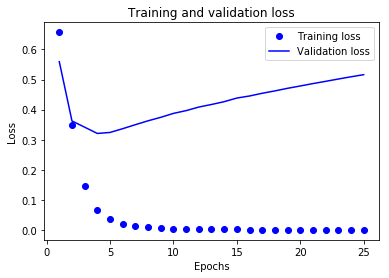

In [10]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

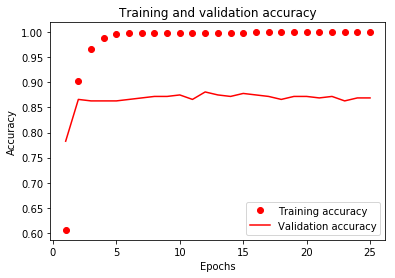

In [11]:
# "bo" is for "blue dot"
plt.plot(epochs, acc, 'ro', label='Training accuracy')
# b is for "solid blue line"
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

## Improving

Let's try try add regularization and a dropout layer. Let's also use 5-fold cross validation to prevent overfitting.

In [41]:
from keras import regularizers
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
cvscores = []

X = df['review']
y = np.array(df['deceptive']).ravel()

X = tokenize(X)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
             
for train, test in kfold.split(X_tokens, y):
    model = keras.Sequential([
    keras.layers.Dense(4, activation=tf.nn.relu, input_shape=(NUM_WORDS,), kernel_regularizer=regularizers.l2(0.01)),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(4, activation=tf.nn.relu, kernel_regularizer=regularizers.l2(0.01)),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
    ])
 
    model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

    model.fit(X[train], y[train], epochs=50, batch_size=8, validation_split=0.3, verbose=1, callbacks=[early_stop])
    scores = model.evaluate(X[test], y[test], verbose=2)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
    
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))


Train on 896 samples, validate on 384 samples
Epoch 1/50
896/896 [==============================] - 3s 4ms/step - loss: 0.7431 - acc: 0.5759 - val_loss: 0.6649 - val_acc: 0.7526
Epoch 2/50
896/896 [==============================] - 1s 659us/step - loss: 0.5683 - acc: 0.7489 - val_loss: 0.5403 - val_acc: 0.8411
Epoch 3/50
896/896 [==============================] - 1s 717us/step - loss: 0.4116 - acc: 0.8493 - val_loss: 0.4553 - val_acc: 0.8568
Epoch 4/50
896/896 [==============================] - 1s 738us/step - loss: 0.3435 - acc: 0.8884 - val_loss: 0.4271 - val_acc: 0.8672
Epoch 5/50
896/896 [==============================] - 1s 757us/step - loss: 0.2919 - acc: 0.9330 - val_loss: 0.4144 - val_acc: 0.8932
Epoch 6/50
896/896 [==============================] - 1s 765us/step - loss: 0.2440 - acc: 0.9632 - val_loss: 0.4220 - val_acc: 0.8724
Epoch 7/50
896/896 [==============================] - 1s 765us/step - loss: 0.2192 - acc: 0.9621 - val_loss: 0.4315 - val_acc: 0.8568
Epoch 8/50
896/896

86% is very good, and a definite improvement. The early stopping also helps hugely.
Now let's see what a better word representation does for us. Let's try use word embeddings as our festure set.

In [44]:
import gensim
from gensim.models import KeyedVectors

vectors = KeyedVectors.load('../wordvec/opspam_w2v.kv')
label_encoder = LabelEncoder()
tokenizer = text.Tokenizer(num_words=5000)

X = df['review']
y = np.array(df['deceptive']).ravel()

y = label_encoder.fit_transform(y)

tokenizer.fit_on_texts(X)
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1

X_sequences = np.array(tokenizer.texts_to_sequences(X))

print(vocab_size)

9839


In [47]:
embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in word_index.items():
    if word in vectors.wv.vocab:
        vector = vectors.wv[word]
    else:
        vector = None
    if vector is not None: 
        embedding_matrix[i] = np.array(vector, dtype=np.float32)
        
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
print(nonzero_elements/vocab_size)
print(embedding_matrix.shape)

0.938408374834841
(9839, 100)


In [50]:
from keras.preprocessing.sequence import pad_sequences
maxlen = 512
X = pad_sequences(X_sequences, padding='post', maxlen=maxlen)

for train, test in kfold.split(X, y):
    model = keras.Sequential([
        keras.layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=maxlen, trainable=False),
        keras.layers.GlobalMaxPool1D(),
        keras.layers.Dense(4, activation=tf.nn.relu, kernel_regularizer=regularizers.l2(0.01)),
        keras.layers.Dense(1, activation=tf.nn.sigmoid)
        ])
    model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
    model.fit(X[train], y[train], epochs=50, batch_size=8, validation_split=0.3, verbose=1, callbacks=[early_stop])
    scores = model.evaluate(X[test], y[test], verbose=2)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
    
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

Train on 896 samples, validate on 384 samples
Epoch 1/50
896/896 [==============================] - 4s 4ms/step - loss: 0.7468 - acc: 0.5022 - val_loss: 0.7250 - val_acc: 0.5781
Epoch 2/50
896/896 [==============================] - 1s 826us/step - loss: 0.7196 - acc: 0.5458 - val_loss: 0.7076 - val_acc: 0.6276
Epoch 3/50
896/896 [==============================] - 1s 1ms/step - loss: 0.7068 - acc: 0.5971 - val_loss: 0.7025 - val_acc: 0.5703
Epoch 4/50
896/896 [==============================] - 1s 1ms/step - loss: 0.7008 - acc: 0.6094 - val_loss: 0.6947 - val_acc: 0.6432
Epoch 5/50
896/896 [==============================] - 1s 1ms/step - loss: 0.6949 - acc: 0.6150 - val_loss: 0.6904 - val_acc: 0.6354
Epoch 6/50
896/896 [==============================] - 1s 1ms/step - loss: 0.6942 - acc: 0.5815 - val_loss: 0.6881 - val_acc: 0.5781
Epoch 7/50
896/896 [==============================] - 1s 989us/step - loss: 0.6915 - acc: 0.5960 - val_loss: 0.6853 - val_acc: 0.6667
Epoch 8/50
896/896 [======

896/896 [==============================] - 1s 1ms/step - loss: 0.6711 - acc: 0.6842 - val_loss: 0.6717 - val_acc: 0.6667
Epoch 14/50
896/896 [==============================] - 1s 1ms/step - loss: 0.6713 - acc: 0.6339 - val_loss: 0.6687 - val_acc: 0.6641
Epoch 15/50
896/896 [==============================] - 1s 1ms/step - loss: 0.6717 - acc: 0.6462 - val_loss: 0.6675 - val_acc: 0.6536
Epoch 16/50
896/896 [==============================] - 1s 1ms/step - loss: 0.6648 - acc: 0.6808 - val_loss: 0.6634 - val_acc: 0.6615
Epoch 17/50
896/896 [==============================] - 1s 952us/step - loss: 0.6639 - acc: 0.6652 - val_loss: 0.6658 - val_acc: 0.6536
Epoch 18/50
896/896 [==============================] - 1s 1ms/step - loss: 0.6597 - acc: 0.6518 - val_loss: 0.6610 - val_acc: 0.6589
Epoch 19/50
896/896 [==============================] - 1s 1ms/step - loss: 0.6601 - acc: 0.6596 - val_loss: 0.6630 - val_acc: 0.6484
Epoch 20/50
896/896 [==============================] - 1s 1ms/step - loss: 0.65

In [51]:
for train, test in kfold.split(X, y):
    model = keras.Sequential([
        keras.layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=maxlen, trainable=True),
        keras.layers.GlobalMaxPool1D(),
        keras.layers.Dense(4, activation=tf.nn.relu, kernel_regularizer=regularizers.l2(0.01)),
        keras.layers.Dense(1, activation=tf.nn.sigmoid)
        ])
    model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
    model.fit(X[train], y[train], epochs=50, batch_size=8, validation_split=0.3, verbose=1, callbacks=[early_stop])
    scores = model.evaluate(X[test], y[test], verbose=2)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
    
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

/Users/niallwalsh/miniconda3/envs/lucas/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 896 samples, validate on 384 samples
Epoch 1/50
896/896 [==============================] - 13s 15ms/step - loss: 0.7894 - acc: 0.4989 - val_loss: 0.7420 - val_acc: 0.5859
Epoch 2/50
896/896 [==============================] - 10s 11ms/step - loss: 0.7196 - acc: 0.6440 - val_loss: 0.7081 - val_acc: 0.7135
Epoch 3/50
896/896 [==============================] - 10s 11ms/step - loss: 0.6768 - acc: 0.7478 - val_loss: 0.6747 - val_acc: 0.7812
Epoch 4/50
896/896 [==============================] - 10s 11ms/step - loss: 0.6321 - acc: 0.7801 - val_loss: 0.6366 - val_acc: 0.7344
Epoch 5/50
896/896 [==============================] - 9s 11ms/step - loss: 0.5664 - acc: 0.8025 - val_loss: 0.5918 - val_acc: 0.7839
Epoch 6/50
896/896 [==============================] - 9s 11ms/step - loss: 0.5041 - acc: 0.8382 - val_loss: 0.5582 - val_acc: 0.7969
Epoch 7/50
896/896 [==============================] - 9s 10ms/step - loss: 0.4515 - acc: 0.8583 - val_loss: 0.5407 - val_acc: 0.8047
Epoch 8/50
896/896 

896/896 [==============================] - 8s 9ms/step - loss: 0.1003 - acc: 0.9989 - val_loss: 0.4550 - val_acc: 0.8151
Epoch 31/50
896/896 [==============================] - 11s 13ms/step - loss: 0.0957 - acc: 0.9989 - val_loss: 0.4546 - val_acc: 0.8203
Epoch 32/50
896/896 [==============================] - 10s 11ms/step - loss: 0.0920 - acc: 0.9989 - val_loss: 0.4565 - val_acc: 0.8177
Epoch 33/50
896/896 [==============================] - 9s 10ms/step - loss: 0.0880 - acc: 0.9989 - val_loss: 0.4546 - val_acc: 0.8177
Epoch 34/50
896/896 [==============================] - 9s 10ms/step - loss: 0.0845 - acc: 0.9989 - val_loss: 0.4507 - val_acc: 0.8255
Epoch 35/50
896/896 [==============================] - 10s 11ms/step - loss: 0.0805 - acc: 1.0000 - val_loss: 0.4498 - val_acc: 0.8177
Epoch 36/50
896/896 [==============================] - 11s 13ms/step - loss: 0.0777 - acc: 0.9989 - val_loss: 0.4522 - val_acc: 0.8203
Epoch 37/50
896/896 [==============================] - 9s 10ms/step - l

When we allow the model to train our embedding layer, we get high accuracies, low loss, and the model does not converge as fast. This leads me to believe that word embeddings are definitley a good feature set, and produce a more generalizing model.